In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import warnings
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
df_results = pd.read_csv('results.csv')
df_goalscorers = pd.read_csv('goalscorers.csv')
df_shootouts = pd.read_csv('shootouts.csv')


# Section A - Data Exploration & Visualization

In [3]:
df_results

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False
...,...,...,...,...,...,...,...,...,...
47320,2024-07-06,NaN,NaN,NaN,NaN,UEFA Euro,Düsseldorf,Germany,True
47321,2024-07-06,NaN,NaN,NaN,NaN,UEFA Euro,Berlin,Germany,True
47322,2024-07-09,NaN,NaN,NaN,NaN,UEFA Euro,Munich,Germany,True
47323,2024-07-10,NaN,NaN,NaN,NaN,UEFA Euro,Dortmund,Germany,True


In [4]:
df_goalscorers

,date,home_team,away_team,team,scorer,minute,own_goal,penalty
0,1916-07-02,Chile,Uruguay,Uruguay,José Piendibene,44.0,False,False
1,1916-07-02,Chile,Uruguay,Uruguay,Isabelino Gradín,55.0,False,False
2,1916-07-02,Chile,Uruguay,Uruguay,Isabelino Gradín,70.0,False,False
3,1916-07-02,Chile,Uruguay,Uruguay,José Piendibene,75.0,False,False
4,1916-07-06,Argentina,Chile,Argentina,Alberto Ohaco,2.0,False,False
...,...,...,...,...,...,...,...,...
44124,2024-06-08,Latvia,Lithuania,Lithuania,Armandas Kučys,49.0,False,False
44125,2024-06-08,Latvia,Lithuania,Lithuania,Armandas Kučys,72.0,False,False
44126,2024-06-11,Latvia,Faroe Islands,Latvia,Andrejs Cigaņiks,49.0,False,False
44127,2024-06-11,Lithuania,Estonia,Estonia,Mark Anders Lepik,82.0,False,False


In [5]:
df_shootouts

,date,home_team,away_team,winner,first_shooter
0,1967-08-22,India,Taiwan,Taiwan,NaN
1,1971-11-14,South Korea,Vietnam Republic,South Korea,NaN
2,1972-05-07,South Korea,Iraq,Iraq,NaN
3,1972-05-17,Thailand,South Korea,South Korea,NaN
4,1972-05-19,Thailand,Cambodia,Thailand,NaN
...,...,...,...,...,...
632,2024-03-26,Wales,Poland,Poland,Poland
633,2024-03-26,Georgia,Greece,Georgia,Georgia
634,2024-03-26,Turks and Caicos Islands,Anguilla,Anguilla,Turks and Caicos Islands
635,2024-03-26,British Virgin Islands,United States Virgin Islands,British Virgin Islands,British Virgin Islands


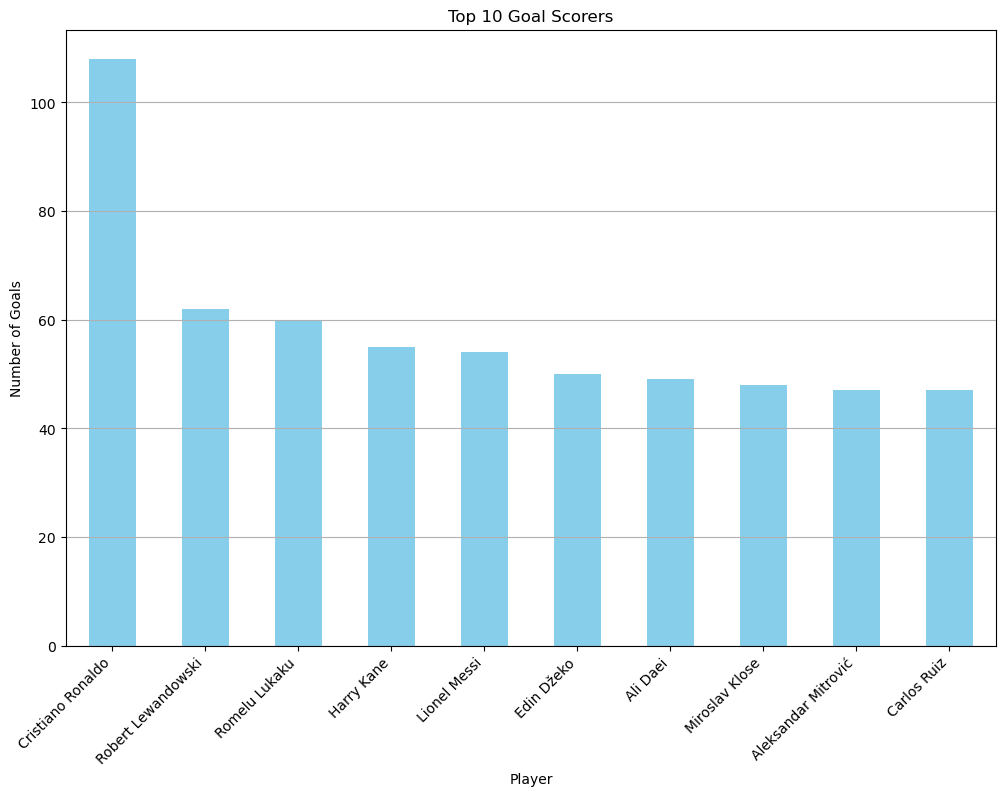

In [6]:
# Top Scorers
top_scorers = df_goalscorers['scorer'].value_counts().head(10)

plt.figure(figsize=(12, 8))
top_scorers.plot(kind='bar', color='skyblue')
plt.title('Top 10 Goal Scorers')
plt.xlabel('Player')
plt.ylabel('Number of Goals')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()



Player Contribution: This visualization highlights the key players who have contributed the most goals, which can be valuable for understanding player performance.

<Figure size 1400x800 with 0 Axes>

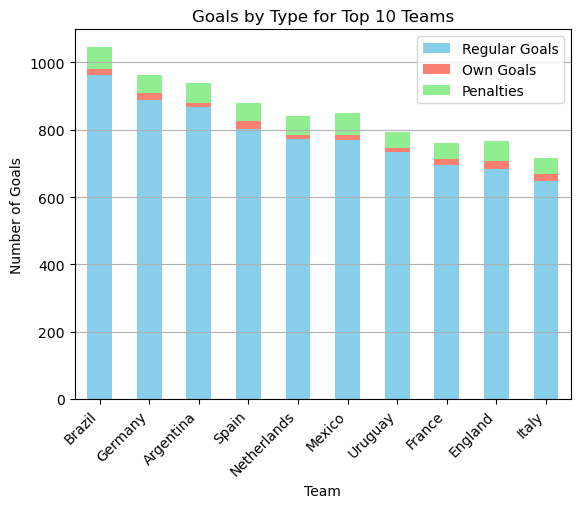

In [7]:
# Goals by Type (Own Goals and Penalties)
goal_types = df_goalscorers.groupby(['team'])[['own_goal', 'penalty']].sum().reset_index()
goal_types['regular_goals'] = df_goalscorers.groupby(['team']).size().values - goal_types['own_goal'] - goal_types['penalty']

goal_types = goal_types.sort_values('regular_goals', ascending=False).head(10)

plt.figure(figsize=(14, 8))
goal_types.set_index('team')[['regular_goals', 'own_goal', 'penalty']].plot(kind='bar', stacked=True, color=['skyblue', 'salmon', 'lightgreen'])
plt.title('Goals by Type for Top 10 Teams')
plt.xlabel('Team')
plt.ylabel('Number of Goals')
plt.xticks(rotation=45, ha='right')
plt.legend(['Regular Goals', 'Own Goals', 'Penalties'])
plt.grid(axis='y')
plt.show()



Observations on Goals by Type for Top 10 Teams  
Regular Goals Dominance: Most of the goals scored by the top teams are regular goals, with own goals and penalty goals contributing less significantly.  
Team Variability: Some teams have a higher number of penalty goals, which may indicate their ability to capitalize on penalty situations.

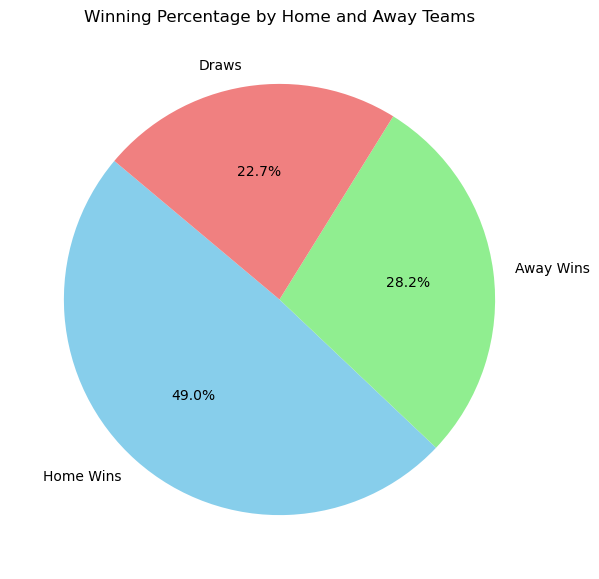

In [8]:
# Winning Percentage by Home and Away Teams
home_wins = df_results[df_results['home_score'] > df_results['away_score']].shape[0]
away_wins = df_results[df_results['home_score'] < df_results['away_score']].shape[0]
draws = df_results[df_results['home_score'] == df_results['away_score']].shape[0]

labels = ['Home Wins', 'Away Wins', 'Draws']
sizes = [home_wins, away_wins, draws]
colors = ['skyblue', 'lightgreen', 'lightcoral']

plt.figure(figsize=(10, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Winning Percentage by Home and Away Teams')
plt.show()


Observations on Winning Percentage by Home and Away Teams  
Home Wins Dominance: Home teams win a majority of the matches, indicating a significant home advantage.  
Away Wins and Draws: Away wins and draws are less frequent, but they still represent a substantial portion of the outcomes.

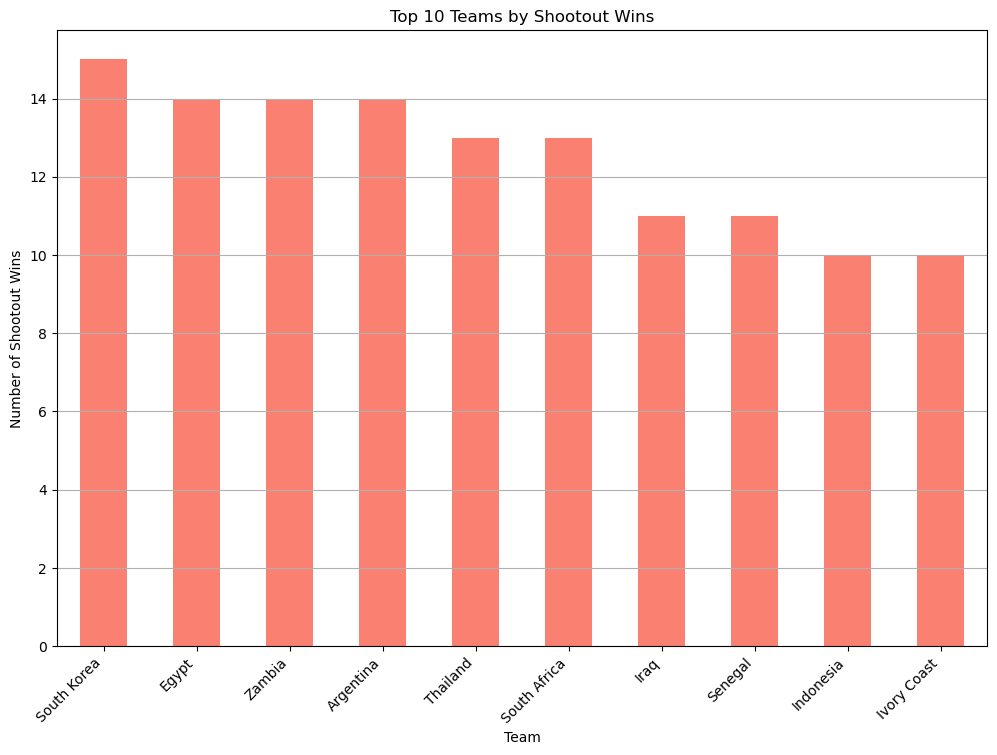

In [9]:
# Shootout Winners
shootout_winners = df_shootouts['winner'].value_counts().head(10)

plt.figure(figsize=(12, 8))
shootout_winners.plot(kind='bar', color='salmon')
plt.title('Top 10 Teams by Shootout Wins')
plt.xlabel('Team')
plt.ylabel('Number of Shootout Wins')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()


Observations on Shootout Winners:  
Frequent Winners: The top teams have a higher number of shootout wins, indicating their proficiency in this high-pressure scenario.  
Team Skill: This can provide insights into which teams are better at handling shootout situations, which could be a valuable factor in strategic planning.

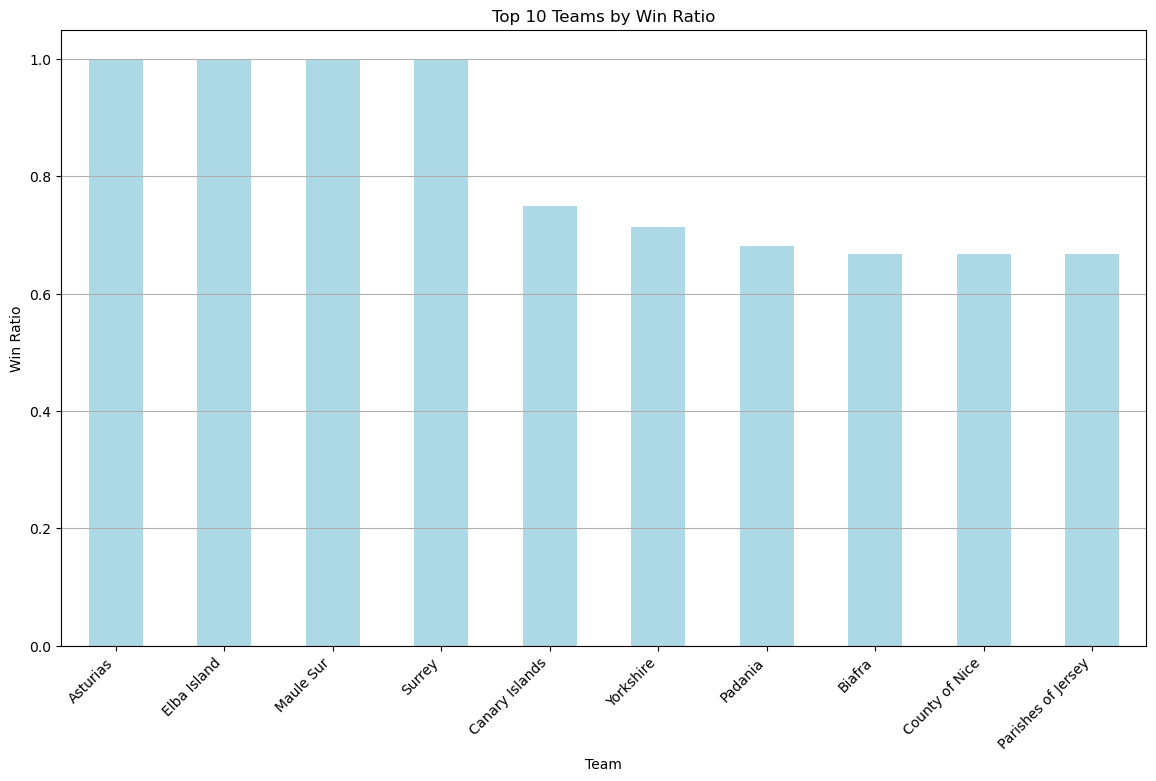

In [10]:
# Top Performing Teams by Win Ratio
win_ratio = df_results[df_results['home_score'] != df_results['away_score']].copy()
win_ratio['winner'] = win_ratio.apply(lambda row: row['home_team'] if row['home_score'] > row['away_score'] else row['away_team'], axis=1)
win_ratio = win_ratio['winner'].value_counts() / df_results['home_team'].value_counts().add(df_results['away_team'].value_counts(), fill_value=0)
top_win_ratio = win_ratio.dropna().sort_values(ascending=False).head(10)

plt.figure(figsize=(14, 8))
top_win_ratio.plot(kind='bar', color='lightblue')
plt.title('Top 10 Teams by Win Ratio')
plt.xlabel('Team')
plt.ylabel('Win Ratio')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()


Observations on Top Performing Teams by Win Ratio  
High Win Ratios: The top teams exhibit high win ratios, indicating consistent performance and success in matches.  
Dominant Teams: These teams are likely to be dominant in their respective leagues or tournaments, making them key contenders to watch.

# Section B - Data Pre-processing

### Home Team Won Feature:

In [11]:
# Convert date to datetime format
df_results['date'] = pd.to_datetime(df_results['date'], errors='coerce')
df_shootouts['date'] = pd.to_datetime(df_shootouts['date'], errors='coerce')

# Initialize the home_team_won column
df_results['home_team_won'] = df_results.apply(
    lambda row: 1 if row['home_score'] > row['away_score'] else 
                (0 if row['home_score'] < row['away_score'] else None), axis=1)

# Handle the draws by looking into the shootouts
drawn_matches = df_results[df_results['home_team_won'].isnull()]
for index, match in drawn_matches.iterrows():
    shootout = df_shootouts[(df_shootouts['date'] == match['date']) & 
                            (df_shootouts['home_team'] == match['home_team']) & 
                            (df_shootouts['away_team'] == match['away_team'])]
    if not shootout.empty:
        if shootout.iloc[0]['winner'] == match['home_team']:
            df_results.at[index, 'home_team_won'] = 1
        else:
            df_results.at[index, 'home_team_won'] = 0

# Replace remaining NaNs with 0 (indicating draws without shootouts)
df_results['home_team_won'] = df_results['home_team_won'].fillna(0)

df_results.head(15)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,home_team_won
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False,0.0
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False,1.0
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False,1.0
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False,0.0
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False,1.0
5,1876-03-25,Scotland,Wales,4.0,0.0,Friendly,Glasgow,Scotland,False,1.0
6,1877-03-03,England,Scotland,1.0,3.0,Friendly,London,England,False,0.0
7,1877-03-05,Wales,Scotland,0.0,2.0,Friendly,Wrexham,Wales,False,0.0
8,1878-03-02,Scotland,England,7.0,2.0,Friendly,Glasgow,Scotland,False,1.0
9,1878-03-23,Scotland,Wales,9.0,0.0,Friendly,Glasgow,Scotland,False,1.0


In [12]:
# Initialize columns
df_results['home_team_win_rate'] = 0.0
df_results['away_team_win_rate'] = 0.0
df_results['home_team_avg_goals'] = 0.0
df_results['away_team_avg_goals'] = 0.0

# Calculate win rates and average goals for each team
teams = df_results['home_team'].unique()

for team in teams:
    team_home_matches = df_results[df_results['home_team'] == team].sort_values('date')
    team_away_matches = df_results[df_results['away_team'] == team].sort_values('date')
    
    for index, row in team_home_matches.iterrows():
        prev_matches = team_home_matches[team_home_matches['date'] < row['date']]
        if not prev_matches.empty:
            win_rate = prev_matches['home_team_won'].mean()
            avg_goals = prev_matches['home_score'].mean()
            df_results.at[index, 'home_team_win_rate'] = win_rate
            df_results.at[index, 'home_team_avg_goals'] = avg_goals
            
    for index, row in team_away_matches.iterrows():
        prev_matches = team_away_matches[team_away_matches['date'] < row['date']]
        if not prev_matches.empty:
            win_rate = (prev_matches['home_team_won'] == 0).mean()
            avg_goals = prev_matches['away_score'].mean()
            df_results.at[index, 'away_team_win_rate'] = win_rate
            df_results.at[index, 'away_team_avg_goals'] = avg_goals

df_results.head(15)


,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,home_team_won,home_team_win_rate,away_team_win_rate,home_team_avg_goals,away_team_avg_goals
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False,0.0,0.000000,0.000000,0.000000,0.000000
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False,1.0,0.000000,0.000000,0.000000,0.000000
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False,1.0,0.000000,1.000000,0.000000,0.000000
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False,0.0,1.000000,0.000000,4.000000,2.000000
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False,1.0,0.500000,0.500000,1.000000,0.500000
5,1876-03-25,Scotland,Wales,4.0,0.0,Friendly,Glasgow,Scotland,False,1.0,0.666667,0.000000,1.666667,0.000000
6,1877-03-03,England,Scotland,1.0,3.0,Friendly,London,England,False,0.0,0.500000,0.500000,3.000000,2.000000
7,1877-03-05,Wales,Scotland,0.0,2.0,Friendly,Wrexham,Wales,False,0.0,0.000000,0.666667,0.000000,2.333333
8,1878-03-02,Scotland,England,7.0,2.0,Friendly,Glasgow,Scotland,False,1.0,0.750000,0.333333,2.250000,0.333333
9,1878-03-23,Scotland,Wales,9.0,0.0,Friendly,Glasgow,Scotland,False,1.0,0.800000,0.000000,3.200000,0.000000


### Implementing Additional Features

Win Streak

Current winning streak for both home and away teams.

In [13]:
# Initialize win streak columns
df_results['home_team_win_streak'] = 0
df_results['away_team_win_streak'] = 0

# Function to calculate win streak without including the current game
def calculate_win_streak(df_results):
    for team in df_results['home_team'].unique():
        team_matches = df_results[(df_results['home_team'] == team) | (df_results['away_team'] == team)].sort_values('date')
        win_streak = 0

        for index, row in team_matches.iterrows():
            if row['home_team'] == team:
                df_results.at[index, 'home_team_win_streak'] = win_streak
                if row['home_team_won'] == 1:
                    win_streak += 1
                else:
                    win_streak = 0
            else:
                df_results.at[index, 'away_team_win_streak'] = win_streak
                if row['home_team_won'] == 0:
                    win_streak += 1
                else:
                    win_streak = 0

    return df_results

# Calculate win streak without including the current game
df_results = calculate_win_streak(df_results)


In [14]:
df_results.head(10)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,home_team_won,home_team_win_rate,away_team_win_rate,home_team_avg_goals,away_team_avg_goals,home_team_win_streak,away_team_win_streak
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False,0.0,0.000000,0.000000,0.000000,0.000000,0,0
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False,1.0,0.000000,0.000000,0.000000,0.000000,1,0
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False,1.0,0.000000,1.000000,0.000000,0.000000,0,2
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False,0.0,1.000000,0.000000,4.000000,2.000000,0,1
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False,1.0,0.500000,0.500000,1.000000,0.500000,2,0
5,1876-03-25,Scotland,Wales,4.0,0.0,Friendly,Glasgow,Scotland,False,1.0,0.666667,0.000000,1.666667,0.000000,3,0
6,1877-03-03,England,Scotland,1.0,3.0,Friendly,London,England,False,0.0,0.500000,0.500000,3.000000,2.000000,0,4
7,1877-03-05,Wales,Scotland,0.0,2.0,Friendly,Wrexham,Wales,False,0.0,0.000000,0.666667,0.000000,2.333333,0,5
8,1878-03-02,Scotland,England,7.0,2.0,Friendly,Glasgow,Scotland,False,1.0,0.750000,0.333333,2.250000,0.333333,6,0
9,1878-03-23,Scotland,Wales,9.0,0.0,Friendly,Glasgow,Scotland,False,1.0,0.800000,0.000000,3.200000,0.000000,7,0


Days Since Last Match (Home)
The number of days since the home team's last match.

In [15]:
# Days Since Last Match (Home)
df_results = df_results.sort_values('date')
df_results['days_since_last_home_match'] = df_results.groupby('home_team')['date'].diff().dt.days.fillna(0)


In [16]:
df_results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,home_team_won,home_team_win_rate,away_team_win_rate,home_team_avg_goals,away_team_avg_goals,home_team_win_streak,away_team_win_streak,days_since_last_home_match
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False,0.0,0.0,0.0,0.0,0.0,0,0,0.0
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False,1.0,0.0,0.0,0.0,0.0,1,0,0.0
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False,1.0,0.0,1.0,0.0,0.0,0,2,462.0
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False,0.0,1.0,0.0,4.0,2.0,0,1,728.0
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False,1.0,0.5,0.5,1.0,0.5,2,0,728.0


Days Since Last Match (Away)
The number of days since the away team's last match.

In [17]:
# Days Since Last Match (Away)
df_results['days_since_last_away_match'] = df_results.groupby('away_team')['date'].diff().dt.days.fillna(0)

In [18]:
df_results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,home_team_won,home_team_win_rate,away_team_win_rate,home_team_avg_goals,away_team_avg_goals,home_team_win_streak,away_team_win_streak,days_since_last_home_match,days_since_last_away_match
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False,1.0,0.0,0.0,0.0,0.0,1,0,0.0,0.0
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False,1.0,0.0,1.0,0.0,0.0,0,2,462.0,462.0
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False,0.0,1.0,0.0,4.0,2.0,0,1,728.0,728.0
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False,1.0,0.5,0.5,1.0,0.5,2,0,728.0,728.0


Seasonality  
The time of the year when the match is played (e.g., month or quarter).

In [19]:
# Seasonality
df_results['month'] = df_results['date'].dt.month
df_results['quarter'] = df_results['date'].dt.quarter


In [20]:
df_results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,home_team_won,home_team_win_rate,away_team_win_rate,home_team_avg_goals,away_team_avg_goals,home_team_win_streak,away_team_win_streak,days_since_last_home_match,days_since_last_away_match,month,quarter
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,11,4
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False,1.0,0.0,0.0,0.0,0.0,1,0,0.0,0.0,3,1
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False,1.0,0.0,1.0,0.0,0.0,0,2,462.0,462.0,3,1
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False,0.0,1.0,0.0,4.0,2.0,0,1,728.0,728.0,3,1
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False,1.0,0.5,0.5,1.0,0.5,2,0,728.0,728.0,3,1


Is Weekend Match  
A boolean feature indicating whether the match was played on a weekend.

In [21]:
# Is Weekend Match
df_results['is_weekend'] = df_results['date'].dt.weekday >= 5


In [22]:
df_results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,home_team_won,...,away_team_win_rate,home_team_avg_goals,away_team_avg_goals,home_team_win_streak,away_team_win_streak,days_since_last_home_match,days_since_last_away_match,month,quarter,is_weekend
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False,0.0,...,0.0,0.0,0.0,0,0,0.0,0.0,11,4,True
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False,1.0,...,0.0,0.0,0.0,1,0,0.0,0.0,3,1,True
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False,1.0,...,1.0,0.0,0.0,0,2,462.0,462.0,3,1,True
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False,0.0,...,0.0,4.0,2.0,0,1,728.0,728.0,3,1,True
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False,1.0,...,0.5,1.0,0.5,2,0,728.0,728.0,3,1,True


In [23]:
df_results['home_team_avg_goals_last_5'] = 0.0
df_results['away_team_avg_goals_last_5'] = 0.0

In [24]:
def calculate_avg_goals_last_5(df, team_col, new_col, score_col):
    for team in df[team_col].unique():
        team_matches = df[df[team_col] == team].sort_values('date')
        prev_goals = []

        for index, row in team_matches.iterrows():
            if len(prev_goals) >= 5:
                df.at[index, new_col] = sum(prev_goals[-5:]) / 5
            elif prev_goals:
                df.at[index, new_col] = sum(prev_goals) / len(prev_goals)
            
            # Collect the goals scored in the current match
            prev_goals.append(row[score_col])

    return df

# Calculate average goals scored in last 5 matches for home and away teams
df_results = calculate_avg_goals_last_5(df_results, 'home_team', 'home_team_avg_goals_last_5', 'home_score')
df_results = calculate_avg_goals_last_5(df_results, 'away_team', 'away_team_avg_goals_last_5', 'away_score')


In [25]:
df_results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,home_team_won,...,away_team_avg_goals,home_team_win_streak,away_team_win_streak,days_since_last_home_match,days_since_last_away_match,month,quarter,is_weekend,home_team_avg_goals_last_5,away_team_avg_goals_last_5
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False,0.0,...,0.0,0,0,0.0,0.0,11,4,True,0.0,0.0
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False,1.0,...,0.0,1,0,0.0,0.0,3,1,True,0.0,0.0
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False,1.0,...,0.0,0,2,462.0,462.0,3,1,True,0.0,0.0
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False,0.0,...,2.0,0,1,728.0,728.0,3,1,True,4.0,2.0
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False,1.0,...,0.5,2,0,728.0,728.0,3,1,True,1.0,0.5


In [26]:
# Print all column names
print(df_results.columns.tolist())


['date', 'home_team', 'away_team', 'home_score', 'away_score', 'tournament', 'city', 'country', 'neutral', 'home_team_won', 'home_team_win_rate', 'away_team_win_rate', 'home_team_avg_goals', 'away_team_avg_goals', 'home_team_win_streak', 'away_team_win_streak', 'days_since_last_home_match', 'days_since_last_away_match', 'month', 'quarter', 'is_weekend', 'home_team_avg_goals_last_5', 'away_team_avg_goals_last_5']


Now we will check for each of the files, how many missing values ​​there are and where

In [27]:

# Function to check for missing values
def check_missing_values(df, df_name):
    missing_values = df.isnull().sum()
    missing_values = missing_values[missing_values > 0]
    if not missing_values.empty:
        print(f"Missing values in {df_name}:\n{missing_values}\n")
    else:
        print(f"No missing values in {df_name}\n")

# Check for missing values in each dataset
check_missing_values(df_goalscorers, "Goalscorers")
check_missing_values(df_results, "Results")
check_missing_values(df_shootouts, "Shootouts")


Missing values in Goalscorers:
scorer     49
minute    259
dtype: int64

Missing values in Results:
home_team                     15
away_team                     15
home_score                    58
away_score                    58
home_team_avg_goals_last_5    14
away_team_avg_goals_last_5    14
dtype: int64

Missing values in Shootouts:
first_shooter    414
dtype: int64



## imputation

### goalscorers

In [28]:
# Drop rows with missing values in the scorer column
df_goalscorers = df_goalscorers.dropna(subset=['scorer'])

In [29]:
# Verify the replacement
print(df_goalscorers['scorer'].isnull().sum())

0


Explanation:  it is not possible to select the name of a common player by the median, as this can create unreliable data, the option before us is to delete the records with the missing values in this column.

In [120]:
# Replace missing values in the minute column with the mean
mean_value = df_goalscorers['minute'].mean()
df_goalscorers.loc[:, 'minute'] = df_goalscorers['minute'].fillna(mean_value)

In [121]:
# Verify the replacement
print(df_goalscorers['minute'].isnull().sum())

0


### Results

In this case, the missing data cannot be completed in a way that preserves the reliability of the information, so the preferred option is to delete all game records that do not have information yet.

In [32]:
df_results.dropna(inplace=True)

In [33]:
# Verify that all null records have been dropped
print(df_results.isnull().sum())

date                          0
home_team                     0
away_team                     0
home_score                    0
away_score                    0
tournament                    0
city                          0
country                       0
neutral                       0
home_team_won                 0
home_team_win_rate            0
away_team_win_rate            0
home_team_avg_goals           0
away_team_avg_goals           0
home_team_win_streak          0
away_team_win_streak          0
days_since_last_home_match    0
days_since_last_away_match    0
month                         0
quarter                       0
is_weekend                    0
home_team_avg_goals_last_5    0
away_team_avg_goals_last_5    0
dtype: int64


### Shootouts

In this file, we were faced with several options for action  
One option was to delete the 414 records with the missing information. Such a quantity of records we preferred not to delete.  
Options such as the most common selection are not useful in this case as they can create unreliable information.  
A better option would have been to randomly choose one of the teams to be the first shooter.  
We thought that randomizing the winning team would not be accurate, so we calculated for the complete records what the explanations are for being the   first shooter if you are the winner and what is the probability of being the first shooter if you lose. According to the probabilities we received we   filled in the missing information.

In [34]:
# Filter out rows with missing 'first_shooter' values
complete_records = df_shootouts.dropna(subset=['first_shooter'])

In [35]:
# Calculate the probability of the winning team being the first shooter
winning_first_shooter_count = complete_records[complete_records['winner'] == complete_records['first_shooter']].shape[0]
total_complete_records = complete_records.shape[0]
winning_first_shooter_prob = winning_first_shooter_count / total_complete_records
losing_first_shooter_prob = 1 - winning_first_shooter_prob

In [36]:
print(f"Probability of winning team being first shooter: {winning_first_shooter_prob:.2f}")
print(f"Probability of losing team being first shooter: {losing_first_shooter_prob:.2f}")


Probability of winning team being first shooter: 0.54
Probability of losing team being first shooter: 0.46


In [37]:
# Function to assign 'first_shooter' based on probabilities
def assign_first_shooter(row, win_prob):
    if pd.isnull(row['first_shooter']):
        if np.random.rand() < win_prob:
            return row['winner']
        else:
            return row['home_team'] if row['winner'] != row['home_team'] else row['away_team']
    else:
        return row['first_shooter']

# Apply the function to the DataFrame
df_shootouts['first_shooter'] = df_shootouts.apply(assign_first_shooter, axis=1, win_prob=winning_first_shooter_prob)


In [38]:
# Verify the replacement
print("\nAfter Imputation:")
print(df_shootouts.isnull().sum())


After Imputation:
date             0
home_team        0
away_team        0
winner           0
first_shooter    0
dtype: int64


In [39]:
# Display the first few rows to verify changes
print("\nData Preview After Imputation:")
print(df_shootouts.head(10))


Data Preview After Imputation:
        date    home_team         away_team       winner first_shooter
0 1967-08-22        India            Taiwan       Taiwan         India
1 1971-11-14  South Korea  Vietnam Republic  South Korea   South Korea
2 1972-05-07  South Korea              Iraq         Iraq          Iraq
3 1972-05-17     Thailand       South Korea  South Korea   South Korea
4 1972-05-19     Thailand          Cambodia     Thailand      Thailand
5 1973-04-21      Senegal             Ghana        Ghana         Ghana
6 1973-06-14       Guinea              Mali       Guinea          Mali
7 1973-06-14    Mauritius          Tanzania    Mauritius     Mauritius
8 1973-07-26     Malaysia            Kuwait     Malaysia      Malaysia
9 1973-07-26     Cambodia         Singapore    Singapore      Cambodia


In [40]:
# A final check of the missing values in each of the files
check_missing_values(df_goalscorers, "Goalscorers")
check_missing_values(df_results, "Results")
check_missing_values(df_shootouts, "Shootouts")

No missing values in Goalscorers

No missing values in Results

No missing values in Shootouts



### Transformation and feature selection

In [41]:
# Extract numerical features from the date
df_results['year'] = df_results['date'].dt.year
df_results['month'] = df_results['date'].dt.month
df_results['day'] = df_results['date'].dt.day
df_results['day_of_week'] = df_results['date'].dt.dayofweek  # Monday=0, Sunday=6
df_results['day_of_year'] = df_results['date'].dt.dayofyear


In [42]:
# Drop the specified columns we don't need for the next sections 
df_results = df_results.drop(columns=['date', 'home_score', 'away_score'])

# Display all column names to confirm the removal
print(df_results.columns.tolist())

['home_team', 'away_team', 'tournament', 'city', 'country', 'neutral', 'home_team_won', 'home_team_win_rate', 'away_team_win_rate', 'home_team_avg_goals', 'away_team_avg_goals', 'home_team_win_streak', 'away_team_win_streak', 'days_since_last_home_match', 'days_since_last_away_match', 'month', 'quarter', 'is_weekend', 'home_team_avg_goals_last_5', 'away_team_avg_goals_last_5', 'year', 'day', 'day_of_week', 'day_of_year']


#### Normalizing Numeric Features

In [43]:
# List of numeric features
numeric_features = [
    'home_team_win_rate', 'away_team_win_rate', 'home_team_avg_goals', 
    'away_team_avg_goals', 'home_team_win_streak', 'away_team_win_streak',
    'days_since_last_home_match', 'days_since_last_away_match', 'month', 
    'quarter', 'home_team_avg_goals_last_5', 'away_team_avg_goals_last_5', 
    'year', 'day', 'day_of_week', 'day_of_year'
]

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the numeric features
df_results[numeric_features] = scaler.fit_transform(df_results[numeric_features])

In [44]:
# Display the first few rows to verify the scaling
print(df_results.head())

  home_team away_team tournament     city   country  neutral  home_team_won  \
0  Scotland   England   Friendly  Glasgow  Scotland    False            0.0   
1   England  Scotland   Friendly   London   England    False            1.0   
2  Scotland   England   Friendly  Glasgow  Scotland    False            1.0   
3   England  Scotland   Friendly   London   England    False            0.0   
4  Scotland   England   Friendly  Glasgow  Scotland    False            1.0   

   home_team_win_rate  away_team_win_rate  home_team_avg_goals  ...  \
0           -2.954209           -2.619680            -2.750979  ...   
1           -2.954209           -2.619680            -2.750979  ...   
2           -2.954209            3.048627            -2.750979  ...   
3            3.181264           -2.619680             3.097464  ...   
4            0.113527            0.214473            -1.288868  ...   

   days_since_last_away_match     month   quarter  is_weekend  \
0                   -0.277156  1.

#### Encode Categorical Variables:

In [45]:
# Select categorical features to encode
categorical_features = ['home_team', 'away_team', 'tournament', 'city', 'country', 'neutral', 'is_weekend']

# Perform one-hot encoding
df_results_encoded = pd.get_dummies(df_results, columns=categorical_features, drop_first=True)

# Ensure all boolean columns are converted to integers
boolean_columns = df_results_encoded.select_dtypes(include=['bool']).columns
for col in boolean_columns:
    df_results_encoded[col] = df_results_encoded[col].astype(int)

# Ensure only numeric types are included
numeric_results_df_encoded = df_results_encoded.select_dtypes(include=[np.number])


In [46]:
# Apply variance threshold to remove low variance features
selector = VarianceThreshold(threshold=0.01)
df_results_reduced = selector.fit_transform(numeric_results_df_encoded)

# Get the selected feature names
selected_features = numeric_results_df_encoded.columns[selector.get_support(indices=True)]

print("\nSelected Features after Variance Threshold:")
print(len(selected_features))

# Convert the selected features back to a DataFrame
df_results_selected = pd.DataFrame(df_results_reduced, columns=selected_features)

# Display the selected features
#print("\nData Preview after Feature Selection:")
#print(df_results_selected.head())


Selected Features after Variance Threshold:
66


# Section C - Home team winning

In [47]:
features_to_drop = ['home_team_won']
X = df_results.drop(columns=features_to_drop)
y = df_results['home_team_won']

In [48]:
# Ensure all categorical features are encoded
X = pd.get_dummies(X, drop_first=True)

In [49]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
# Display the shapes of the training and testing sets
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(37813, 3175) (9454, 3175) (37813,) (9454,)


In [51]:
# Initialize the models
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'AdaBoost': AdaBoostClassifier()
}

In [52]:
# Dictionary to store the performance of each model
model_performance = {}

for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Store the performance metrics
    model_performance[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }


In [53]:
# Display the performance of each model
for model_name, performance in model_performance.items():
    print(f"Model: {model_name}")
    for metric, value in performance.items():
        print(f"  {metric}: {value:.4f}")

Model: Decision Tree
  Accuracy: 0.5835
  Precision: 0.5804
  Recall: 0.5883
  F1 Score: 0.5843
Model: Random Forest
  Accuracy: 0.6567
  Precision: 0.6577
  Recall: 0.6468
  F1 Score: 0.6522
Model: AdaBoost
  Accuracy: 0.6514
  Precision: 0.6536
  Recall: 0.6372
  F1 Score: 0.6453


In [54]:
# Define parameter grids for each model
param_grids = {
    'Decision Tree': {
        'max_depth': [None, 5, 10, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Random Forest': {
        'n_estimators': [20, 30, 50],
        'max_depth': [None, 5, 10, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'AdaBoost': {
        'n_estimators': [20, 30, 50],
        'learning_rate': [0.01, 0.1, 1, 10]
    }
}

In [55]:
# Perform GridSearchCV for each model
best_params = {}
for model_name, param_grid in param_grids.items():
    grid_search = GridSearchCV(models[model_name], param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_params[model_name] = grid_search.best_params_
    models[model_name] = grid_search.best_estimator_

In [56]:
# Display the best parameters for each model
print("Best Parameters:")
for model_name, params in best_params.items():
    print(f"{model_name}: {params}")

Best Parameters:
Decision Tree: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Random Forest: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
AdaBoost: {'learning_rate': 1, 'n_estimators': 50}


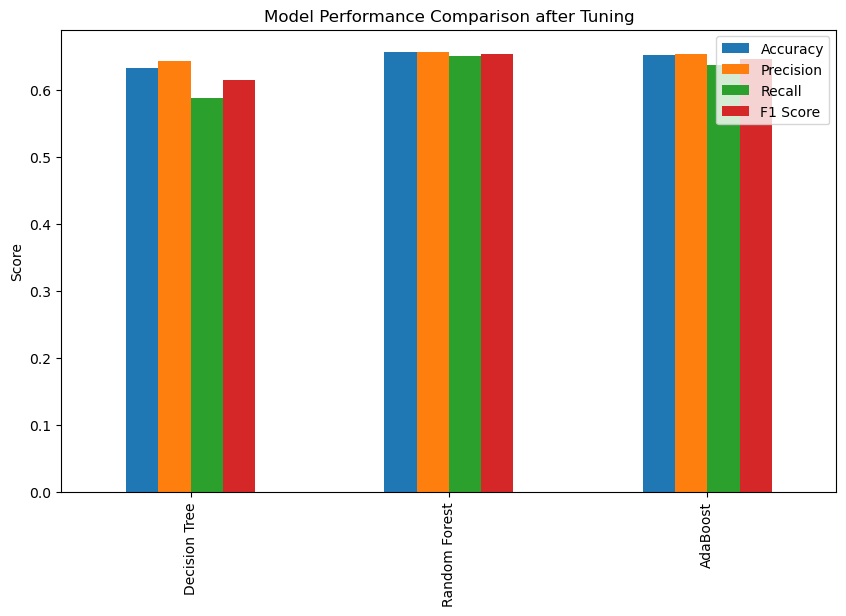

In [57]:
# Retrain the models with the best parameters and evaluate them again
model_performance_tuned = {}
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Store the performance metrics
    model_performance_tuned[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

# Convert model performance to a DataFrame for better visualization
performance_df = pd.DataFrame(model_performance_tuned).T

# Plot the performance of each model
performance_df.plot(kind='bar', figsize=(10, 6))
plt.title('Model Performance Comparison after Tuning')
plt.ylabel('Score')
plt.show()


A graph depicts the performance of three machine learning models; the Decision Tree, Random Forest and AdaBoost in predicting whether the home team will win. Four metrics namely Accuracy, Precision, Recall and F1 Score are used to evaluate each model. The Random Forest model performs slightly better in all aspects of these metrics when compared with Decision Tree and AdaBoost models. This suggests that using ensembles, Random Forest can detect underlying patterns more precisely than others. The fact that performances between these models are similar implies that selected features are quite informative but there is a need to improve feature engineering or model tuning for better predictive accuracy.

# Section D - Clustering

In [58]:
results_df = pd.read_csv('results.csv')

In [59]:
results_df = results_df.dropna()

In [60]:
# Initialize the home_team_won and away_team_won columns with default values (False)
results_df['home_team_won'] = False
results_df['away_team_won'] = False

# Determine the winner based on scores
results_df.loc[results_df['home_score'] > results_df['away_score'], 'home_team_won'] = True
results_df.loc[results_df['home_score'] < results_df['away_score'], 'away_team_won'] = True

# Handle draws by referring to the shootouts dataset
draws = results_df[results_df['home_score'] == results_df['away_score']]
for index, row in draws.iterrows():
    shootout = df_shootouts[(df_shootouts['date'] == row['date']) & 
                            (df_shootouts['home_team'] == row['home_team']) & 
                            (df_shootouts['away_team'] == row['away_team'])]
    if not shootout.empty:
        if shootout['winner'].values[0] == row['home_team']:
            results_df.at[index, 'home_team_won'] = True
        elif shootout['winner'].values[0] == row['away_team']:
            results_df.at[index, 'away_team_won'] = True

In [61]:
# Display the first few rows of the updated results dataset
print(results_df.head())

         date home_team away_team  home_score  away_score tournament     city  \
0  1872-11-30  Scotland   England         0.0         0.0   Friendly  Glasgow   
1  1873-03-08   England  Scotland         4.0         2.0   Friendly   London   
2  1874-03-07  Scotland   England         2.0         1.0   Friendly  Glasgow   
3  1875-03-06   England  Scotland         2.0         2.0   Friendly   London   
4  1876-03-04  Scotland   England         3.0         0.0   Friendly  Glasgow   

    country  neutral  home_team_won  away_team_won  
0  Scotland    False          False          False  
1   England    False           True          False  
2  Scotland    False           True          False  
3   England    False          False          False  
4  Scotland    False           True          False  


In [62]:
# Create a dataset where each row represents a team
teams = pd.concat([results_df['home_team'], results_df['away_team']]).unique()
team_stats = pd.DataFrame(teams, columns=['team'])

# Initialize columns
team_stats['total_wins'] = 0
team_stats['win_rate'] = 0.0
team_stats['home_win_rate'] = 0.0
team_stats['away_win_rate'] = 0.0
team_stats['avg_goals_scored_in_wins'] = 0.0
team_stats['avg_goals_conceded_in_wins'] = 0.0
team_stats['winning_streak'] = 0

# Calculate features
for team in teams:
    total_games = results_df[(results_df['home_team'] == team) | (results_df['away_team'] == team)].shape[0]
    total_wins = results_df[(results_df['home_team'] == team) & (results_df['home_team_won'] == True)].shape[0] + \
                 results_df[(results_df['away_team'] == team) & (results_df['away_team_won'] == True)].shape[0]
    home_games = results_df[results_df['home_team'] == team].shape[0]
    away_games = results_df[results_df['away_team'] == team].shape[0]
    home_wins = results_df[(results_df['home_team'] == team) & (results_df['home_team_won'] == True)].shape[0]
    away_wins = results_df[(results_df['away_team'] == team) & (results_df['away_team_won'] == True)].shape[0]
    
    win_rate = total_wins / total_games if total_games > 0 else 0
    home_win_rate = home_wins / home_games if home_games > 0 else 0
    away_win_rate = away_wins / away_games if away_games > 0 else 0
    
    team_stats.loc[team_stats['team'] == team, 'total_wins'] = total_wins
    team_stats.loc[team_stats['team'] == team, 'win_rate'] = win_rate
    team_stats.loc[team_stats['team'] == team, 'home_win_rate'] = home_win_rate
    team_stats.loc[team_stats['team'] == team, 'away_win_rate'] = away_win_rate

    home_wins = results_df[(results_df['home_team'] == team) & (results_df['home_team_won'] == True)]
    away_wins = results_df[(results_df['away_team'] == team) & (results_df['away_team_won'] == True)]
    
    total_wins = pd.concat([home_wins, away_wins])
    
    total_goals_scored = home_wins['home_score'].sum() + away_wins['away_score'].sum()
    total_goals_conceded = home_wins['away_score'].sum() + away_wins['home_score'].sum()
    
    avg_goals_scored_in_wins = total_goals_scored / total_wins.shape[0] if total_wins.shape[0] > 0 else 0
    avg_goals_conceded_in_wins = total_goals_conceded / total_wins.shape[0] if total_wins.shape[0] > 0 else 0
    
    team_stats.loc[team_stats['team'] == team, 'avg_goals_scored_in_wins'] = avg_goals_scored_in_wins
    team_stats.loc[team_stats['team'] == team, 'avg_goals_conceded_in_wins'] = avg_goals_conceded_in_wins

    team_games = results_df[(results_df['home_team'] == team) | (results_df['away_team'] == team)].sort_values('date')
    streak = 0
    max_streak = 0
    
    for index, row in team_games.iterrows():
        if (row['home_team'] == team and row['home_team_won']) or (row['away_team'] == team and row['away_team_won']):
            streak += 1
        else:
            if streak > max_streak:
                max_streak = streak
            streak = 0
    
    max_streak = max(max_streak, streak)
    
    team_stats.loc[team_stats['team'] == team, 'winning_streak'] = max_streak

In [63]:
# Display the first few rows of the team_stats dataset
print(team_stats.head())

               team  total_wins  win_rate  home_win_rate  away_win_rate  \
0          Scotland         394  0.475845       0.565757       0.390588   
1           England         609  0.572907       0.623596       0.521739   
2             Wales         226  0.320113       0.386819       0.254902   
3  Northern Ireland         178  0.259098       0.333333       0.190476   
4     United States         339  0.450199       0.560086       0.271777   

   avg_goals_scored_in_wins  avg_goals_conceded_in_wins  winning_streak  
0                  2.799492                    0.583756              13  
1                  3.200328                    0.563218              10  
2                  2.442478                    0.500000               6  
3                  2.247191                    0.432584               5  
4                  2.548673                    0.457227              11  


### We'll use K-Means and Agglomerative Clustering algorithms.

In [64]:
# Filter warnings
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')
warnings.filterwarnings("ignore", category=FutureWarning)

In [65]:
# Standardize the features
scaler = StandardScaler()
team_data_scaled = scaler.fit_transform(team_stats.drop(columns=['team']))

In [66]:
# Apply K-Means Clustering with n_init explicitly set
kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
team_stats['kmeans_cluster'] = kmeans.fit_predict(team_data_scaled)

We chose the parameter to be 4 according to the graph we presented below. There you can see a sharp change according to which we knew to take the parameter to be 4

In [67]:
# Apply Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=3)
team_stats['agglo_cluster'] = agglo.fit_predict(team_data_scaled)

In [68]:
# Display the first few rows of the team dataset with cluster labels
print(team_stats.head())

               team  total_wins  win_rate  home_win_rate  away_win_rate  \
0          Scotland         394  0.475845       0.565757       0.390588   
1           England         609  0.572907       0.623596       0.521739   
2             Wales         226  0.320113       0.386819       0.254902   
3  Northern Ireland         178  0.259098       0.333333       0.190476   
4     United States         339  0.450199       0.560086       0.271777   

   avg_goals_scored_in_wins  avg_goals_conceded_in_wins  winning_streak  \
0                  2.799492                    0.583756              13   
1                  3.200328                    0.563218              10   
2                  2.442478                    0.500000               6   
3                  2.247191                    0.432584               5   
4                  2.548673                    0.457227              11   

   kmeans_cluster  agglo_cluster  
0               1              2  
1               1           

In [69]:
# Determine the optimal number of clusters for K-Means using the elbow method
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(team_data_scaled)
    sse.append(kmeans.inertia_)


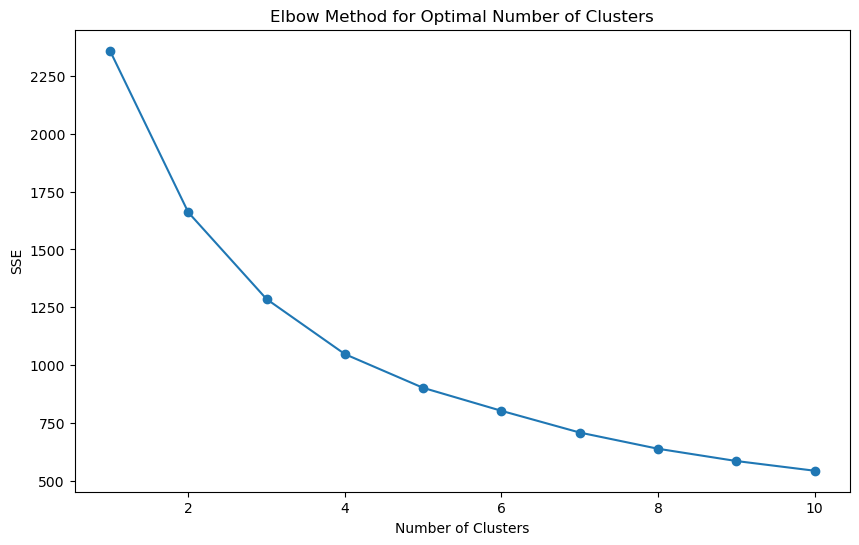

In [70]:
# Plot the SSE for each k
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()


In [71]:
# Calculate silhouette score for K-Means clusters
kmeans_silhouette = silhouette_score(team_data_scaled, team_stats['kmeans_cluster'])
print(f'K-Means Silhouette Score: {kmeans_silhouette:.4f}')

# Calculate silhouette score for Agglomerative clusters
agglo_silhouette = silhouette_score(team_data_scaled, team_stats['agglo_cluster'])
print(f'Agglomerative Clustering Silhouette Score: {agglo_silhouette:.4f}')

K-Means Silhouette Score: 0.3461
Agglomerative Clustering Silhouette Score: 0.2833


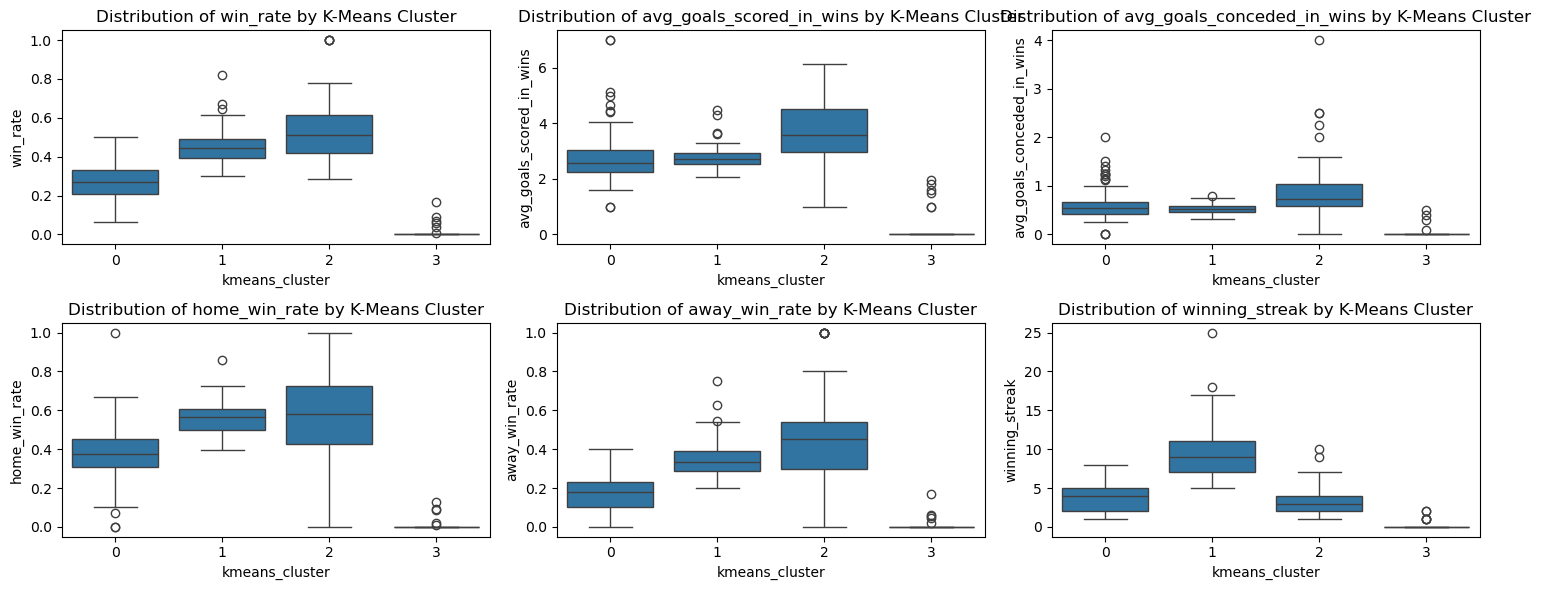

In [72]:
# Plot the distribution of features within each K-Means cluster
plt.figure(figsize=(15, 6))
for i, feature in enumerate(['win_rate', 'avg_goals_scored_in_wins', 'avg_goals_conceded_in_wins', 'home_win_rate', 'away_win_rate', 'winning_streak']):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='kmeans_cluster', y=feature, data=team_stats)
    plt.title(f'Distribution of {feature} by K-Means Cluster')
plt.tight_layout()
plt.show()

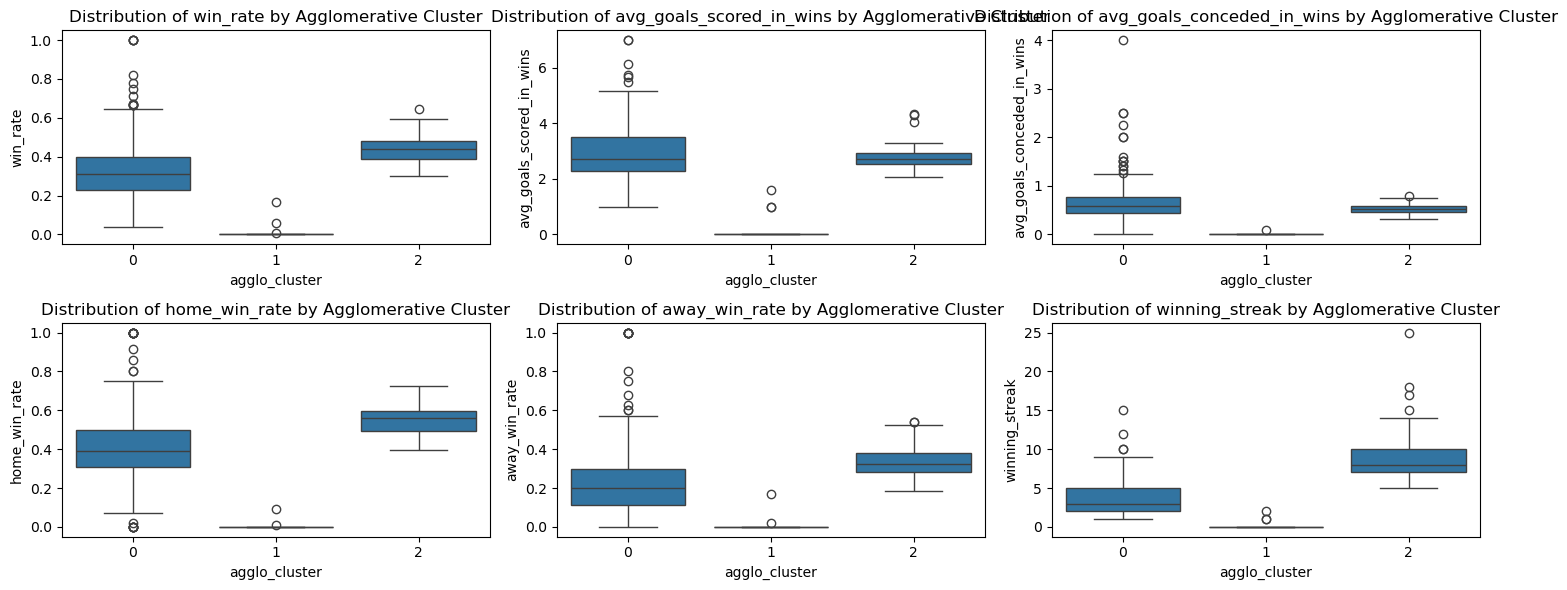

In [73]:
# Plot the distribution of features within each Agglomerative cluster
plt.figure(figsize=(15, 6))
for i, feature in enumerate(['win_rate', 'avg_goals_scored_in_wins', 'avg_goals_conceded_in_wins', 'home_win_rate', 'away_win_rate', 'winning_streak']):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='agglo_cluster', y=feature, data=team_stats)
    plt.title(f'Distribution of {feature} by Agglomerative Cluster')
plt.tight_layout()
plt.show()

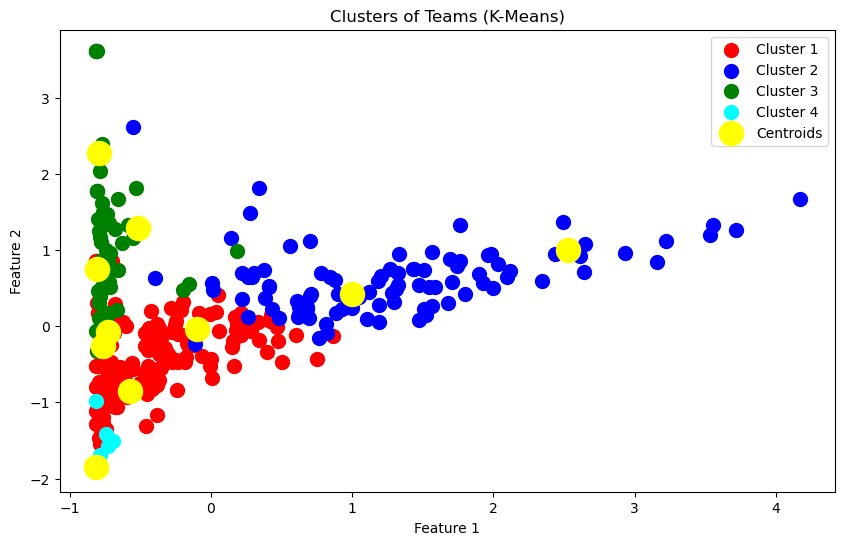

In [74]:
# Scatter plot for K-Means Clustering
plt.figure(figsize=(10, 6))
plt.scatter(team_data_scaled[team_stats['kmeans_cluster'] == 0, 0], 
            team_data_scaled[team_stats['kmeans_cluster'] == 0, 1], 
            s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(team_data_scaled[team_stats['kmeans_cluster'] == 1, 0], 
            team_data_scaled[team_stats['kmeans_cluster'] == 1, 1], 
            s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(team_data_scaled[team_stats['kmeans_cluster'] == 2, 0], 
            team_data_scaled[team_stats['kmeans_cluster'] == 2, 1], 
            s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(team_data_scaled[team_stats['kmeans_cluster'] == 3, 0], 
            team_data_scaled[team_stats['kmeans_cluster'] == 3, 1], 
            s = 100, c = 'cyan', label = 'Cluster 4')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
            s = 300, c = 'yellow', label = 'Centroids')
plt.title('Clusters of Teams (K-Means)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()


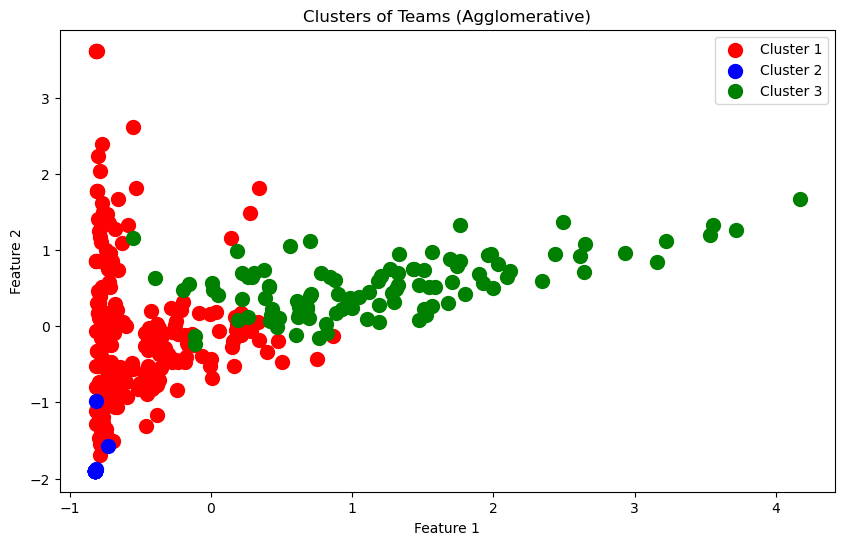

In [75]:
# Scatter plot for Agglomerative Clustering
plt.figure(figsize=(10, 6))
plt.scatter(team_data_scaled[team_stats['agglo_cluster'] == 0, 0], 
            team_data_scaled[team_stats['agglo_cluster'] == 0, 1], 
            s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(team_data_scaled[team_stats['agglo_cluster'] == 1, 0], 
            team_data_scaled[team_stats['agglo_cluster'] == 1, 1], 
            s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(team_data_scaled[team_stats['agglo_cluster'] == 2, 0], 
            team_data_scaled[team_stats['agglo_cluster'] == 2, 1], 
            s = 100, c = 'green', label = 'Cluster 3')
plt.title('Clusters of Teams (Agglomerative)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()


# Section E - Clustering and Dimensions Reduction - Bonus

We'll use PCA to reduce the dimensions of the team data.

In [76]:
# Apply PCA to the team data
pca = PCA(n_components=2)
team_data_pca = pca.fit_transform(team_data_scaled)

# Create a DataFrame to store the PCA results
pca_df = pd.DataFrame(data=team_data_pca, columns=['Principal Component 1', 'Principal Component 2'])
pca_df['team'] = team_stats['team']

# Display the explained variance ratio
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance)

Explained Variance Ratio: [0.48618868 0.22801402]


We'll plot the explained variance to see which principal components explain the majority of the variance.

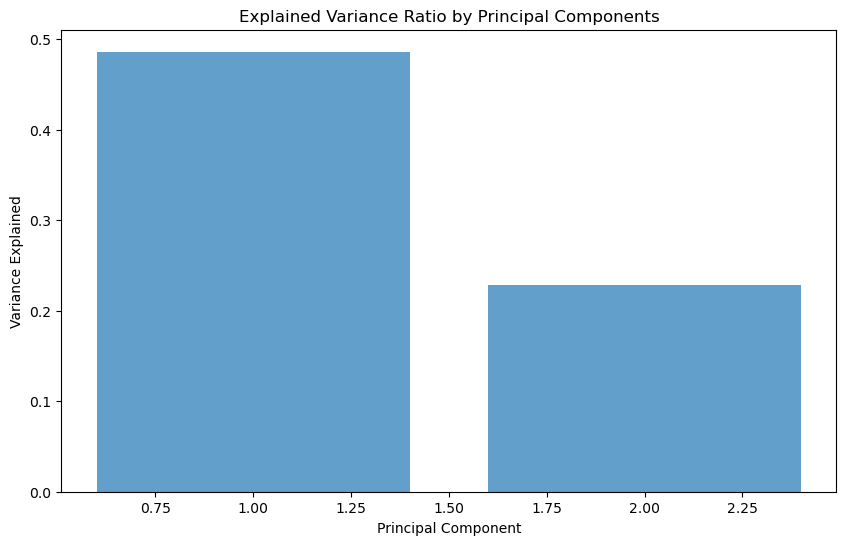

In [77]:
import matplotlib.pyplot as plt

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, align='center')
plt.title('Explained Variance Ratio by Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()


We'll identify which features are most strongly represented in each principal component.

In [102]:
# Print the actual columns in team_stats after dropping 'team'
print("Columns in team_stats after dropping 'team':", team_stats.drop(columns=['team']).columns)

# Ensure the PCA transformation is correctly applied to the same number of columns
team_data_scaled = scaler.fit_transform(team_stats.drop(columns=['team']))
pca = PCA(n_components=2)
team_data_pca = pca.fit_transform(team_data_scaled)

# Get the Loadings (correlation of each feature with the principal components)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Print the shapes to debug
print("Shape of loadings:", loadings.shape)
print("Shape of team_stats columns:", team_stats.drop(columns=['team']).columns.shape)

# Create a DataFrame for the Loadings
n_components = pca.components_.shape[0]
loadings_df = pd.DataFrame(loadings, index=team_stats.drop(columns=['team']).columns, 
                           columns=[f'Principal Component {i+1}' for i in range(n_components)])
print(loadings_df)


Columns in team_stats after dropping 'team': Index(['total_wins', 'win_rate', 'home_win_rate', 'away_win_rate',
       'avg_goals_scored_in_wins', 'avg_goals_conceded_in_wins',
       'winning_streak', 'kmeans_cluster', 'agglo_cluster',
       'kmeans_pca_cluster', 'agglo_pca_cluster'],
      dtype='object')
Shape of loadings: (11, 2)
Shape of team_stats columns: (11,)
                            Principal Component 1  Principal Component 2
total_wins                               0.787095              -0.182096
win_rate                                 0.543657              -0.674613
home_win_rate                            0.426675              -0.720469
away_win_rate                            0.520274              -0.456189
avg_goals_scored_in_wins                -0.017103              -0.807667
avg_goals_conceded_in_wins              -0.166214              -0.573884
winning_streak                           0.758883              -0.362416
kmeans_cluster                           0.3

We'll use the top principal components to perform clustering.

In [103]:
# Apply K-Means Clustering using PCA components
kmeans_pca = KMeans(n_clusters=4, n_init=10, random_state=42)
team_stats['kmeans_pca_cluster'] = kmeans_pca.fit_predict(team_data_pca)

# Apply Agglomerative Clustering using PCA components
agglo_pca = AgglomerativeClustering(n_clusters=3)
team_stats['agglo_pca_cluster'] = agglo_pca.fit_predict(team_data_pca)


We'll compare the clustering results before and after PCA.

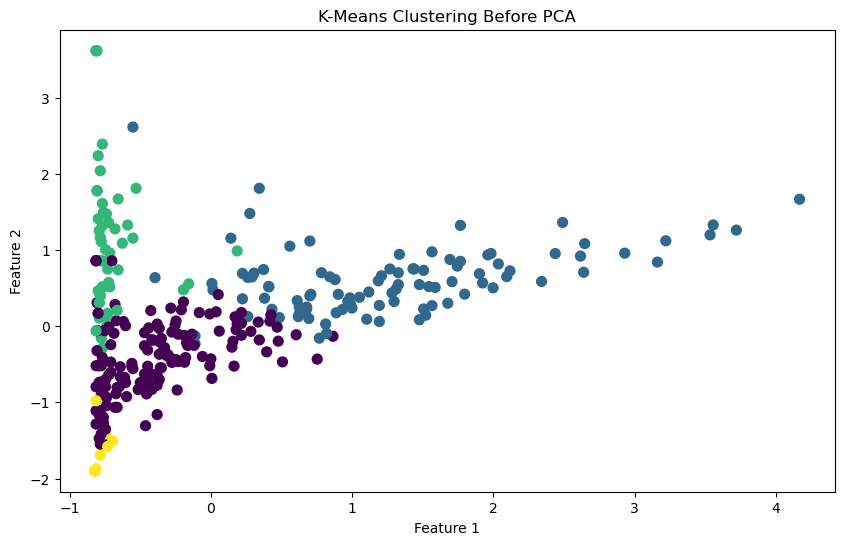

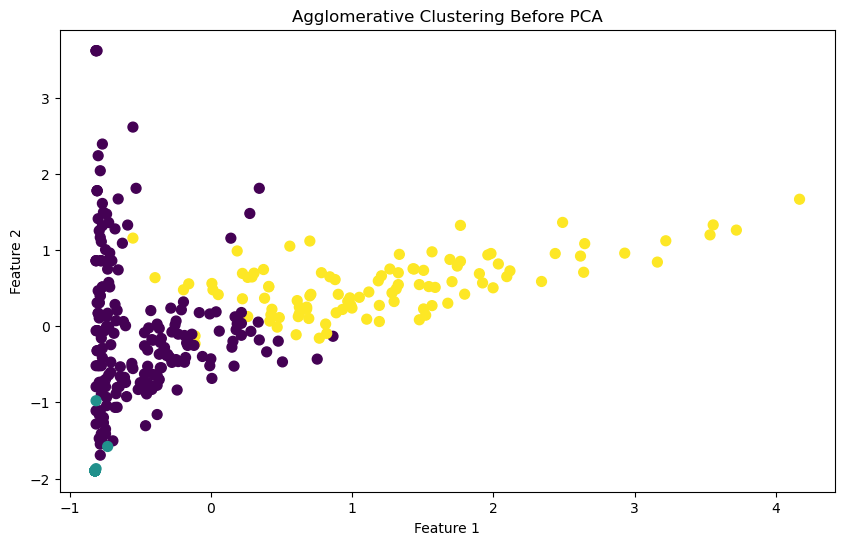

In [104]:
# Plot K-Means Clustering results before PCA
plt.figure(figsize=(10, 6))
plt.scatter(team_data_scaled[:, 0], team_data_scaled[:, 1], c=team_stats['kmeans_cluster'], cmap='viridis', s=50)
plt.title('K-Means Clustering Before PCA')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Plot Agglomerative Clustering results before PCA
plt.figure(figsize=(10, 6))
plt.scatter(team_data_scaled[:, 0], team_data_scaled[:, 1], c=team_stats['agglo_cluster'], cmap='viridis', s=50)
plt.title('Agglomerative Clustering Before PCA')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


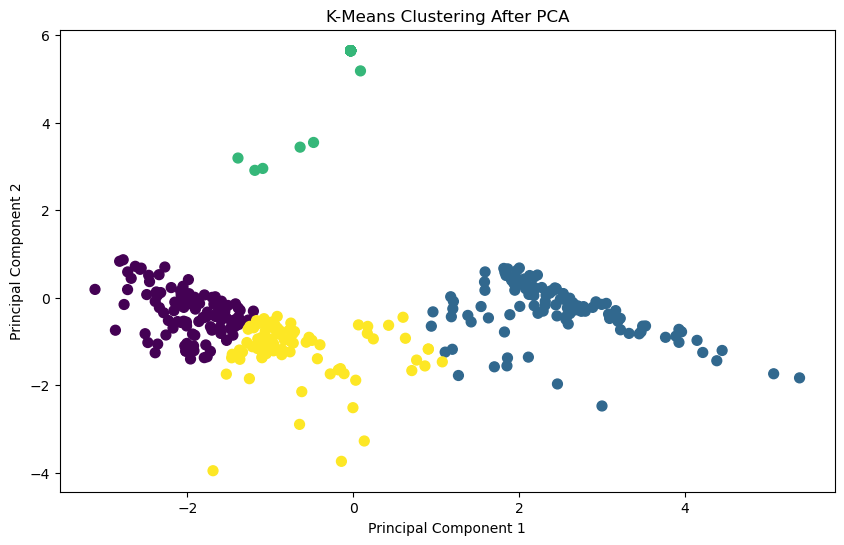

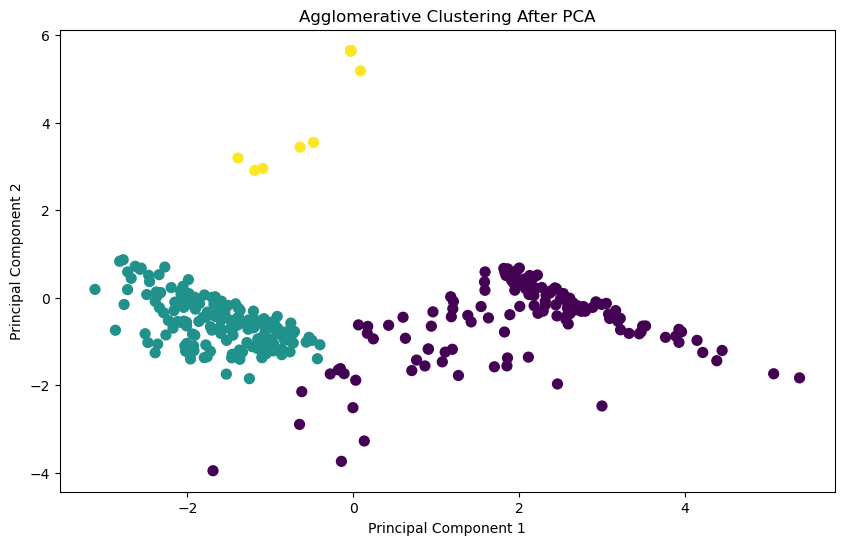

In [105]:
# Plot K-Means Clustering results after PCA
plt.figure(figsize=(10, 6))
plt.scatter(team_data_pca[:, 0], team_data_pca[:, 1], c=team_stats['kmeans_pca_cluster'], cmap='viridis', s=50)
plt.title('K-Means Clustering After PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Plot Agglomerative Clustering results after PCA
plt.figure(figsize=(10, 6))
plt.scatter(team_data_pca[:, 0], team_data_pca[:, 1], c=team_stats['agglo_pca_cluster'], cmap='viridis', s=50)
plt.title('Agglomerative Clustering After PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


Finally, we'll compare the clustering results before and after PCA and discuss any differences.

In [106]:
# Display the clustering results comparison
print("Clustering Results Comparison:")
print(team_stats[['team', 'kmeans_cluster', 'kmeans_pca_cluster', 'agglo_cluster', 'agglo_pca_cluster']].head())


Clustering Results Comparison:
               team  kmeans_cluster  kmeans_pca_cluster  agglo_cluster  \
0          Scotland               1                   1              2   
1           England               1                   1              2   
2             Wales               0                   3              0   
3  Northern Ireland               0                   0              0   
4     United States               1                   1              2   

   agglo_pca_cluster  
0                  0  
1                  0  
2                  1  
3                  1  
4                  0  


# Section F - Exploring Players- we made 2 questions

First, we will create the Player Statistics Dataset

In [107]:
# Group by 'scorer' to calculate player statistics
player_stats = df_goalscorers.groupby('scorer').agg(
    total_goals=('scorer', 'size'),
    avg_goal_minute=('minute', 'mean')
).reset_index()

In [108]:
# Rename the columns for clarity
player_stats.rename(columns={'scorer': 'player'}, inplace=True)

In [109]:
# Display the dataframe
print(player_stats.head())

            player  total_goals  avg_goal_minute
0     A'ala Hubail           13        55.153846
1     A. Elangovan            1        42.000000
2  Aage Rou Jensen            1        85.000000
3      Aaran Lines            3        56.666667
4  Aaron Boupendza            1        16.000000


##  Machine Learning Algorithm

#### First Question:

On the basis of a player’s past performance, is it possible to anticipate the average minute at which he or she will score a goal?

#### Suggested Algorithm:

Linear Regression is appropriate for this regression task.   Because it is simple, interpretable and can help understand   the relationship between past performance and future objectives.

In [110]:
# Prepare the data
X = player_stats[['total_goals']]
y = player_stats['avg_goal_minute']

In [111]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [112]:
# Train the model
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [113]:
# Make predictions
y_pred = model.predict(X_test)


In [114]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 470.4158850919094
R-squared: -0.0005648527627195588


It is obvious that the results obtained are not good at all as we expected them to be. The question here is an unanswerable question, hence making our figures right.

#### Second Question:

In [115]:
# Group by 'scorer' and 'team' to calculate player statistics
player_stats1 = df_goalscorers.groupby(['scorer', 'team']).agg(
    total_goals=('scorer', 'size'),
    avg_goal_minute=('minute', 'mean'),
    total_penalties=('penalty', 'sum')
).reset_index()

In [116]:
# Rename the columns for clarity
player_stats1.rename(columns={'scorer': 'player'}, inplace=True)

In [117]:
# Display the dataframe
print(player_stats.head())

            player  total_goals  avg_goal_minute
0     A'ala Hubail           13        55.153846
1     A. Elangovan            1        42.000000
2  Aage Rou Jensen            1        85.000000
3      Aaran Lines            3        56.666667
4  Aaron Boupendza            1        16.000000


### New Question:
Can we predict the total number of goals a player has based on their average goals, the number of penalties, and the team they play for?

In [118]:
# Prepare the data
# Encode categorical features (player and team)
player_stats_encoded = pd.get_dummies(player_stats1, columns=['player', 'team'], drop_first=True)

# Select features and target
X = player_stats_encoded[['avg_goal_minute', 'total_penalties'] + [col for col in player_stats_encoded.columns if col.startswith('player_') or col.startswith('team_')]]
y = player_stats_encoded['total_goals']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 2.0235192768607408e+17
R-squared: -9550287456001008.0


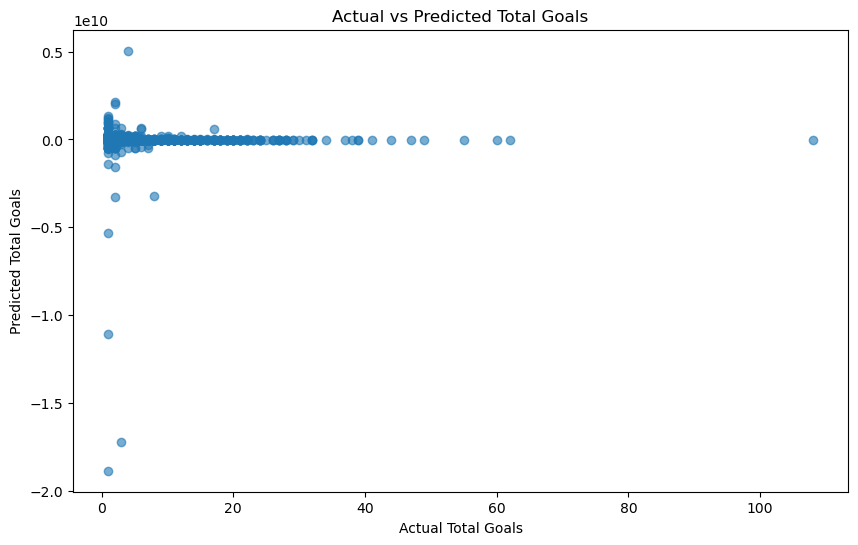

In [119]:
# Display the results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel('Actual Total Goals')
plt.ylabel('Predicted Total Goals')
plt.title('Actual vs Predicted Total Goals')
plt.show()